In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pyterrier as pt
pt.init()

PyTerrier 0.8.1 has loaded Terrier 5.6 (built by craigmacdonald on 2021-09-17 13:27)

No etc/terrier.properties, using terrier.default.properties for bootstrap configuration.


In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [8, 6]

plt.style.use('ggplot')

from matplotlib import rc
rc('ps', useafm=True)
rc('pdf', use14corefonts=True)
rc('text', usetex=True)
rc('font', family='sans-serif')
rc('font', **{'sans-serif': ['Computer Modern']})
rc('font', size=14)
rc('axes', grid=True)

In [3]:
ggplot_colors = ['#E24A33', '#348ABD', '#988ED5', '#777777', '#FBC15E', '#8EBA42', '#FFB5B8']

In [4]:
h2style = {
    "IDF uniform":         'solid',
    "IDF doc-centric":     'dashed',
    "Random doc-centric":  'dotted',
    "MSN uniform":         'solid',
    "MSMARCO uniform":     'solid',
    "MSN doc-centric":     'dashed',
    "MSMARCO doc-centric": 'dashed',
}

h2color = {
    "IDF uniform":         ggplot_colors[0],
    "IDF doc-centric":     ggplot_colors[0],
    "Random doc-centric":  'black',
    "MSN uniform":         ggplot_colors[2],
    "MSMARCO uniform":     ggplot_colors[3],
    "MSN doc-centric":     ggplot_colors[2],
    "MSMARCO doc-centric": ggplot_colors[3],
}

In [5]:
from glob import glob
import os
from pyterrier.measures import *

def eval_and_signifiance(thedir, topics):
    input_df = pd.read_pickle((thedir + "/results_df.pkl") % topics)
    topics_map = { '2019' : 'test-2019', '2020' : 'test-2020', 'dev' : 'dev.small' }
    TQ = (
           pt.get_dataset("msmarco_passage").get_topics(topics_map[topics]), 
           pt.get_dataset("msmarco_passage").get_qrels(topics_map[topics])
        )
    resfiles = glob((thedir + "/*.res.gz") % topics)
    df = pt.Experiment(
        [  
            pt.io.read_results("/nfs/craigm/staticPruning/results/repro/baseline_%s/approx_baseline.res.gz" % topics)
        ]+[
            pt.io.read_results(f) for f in resfiles
        ],
        *TQ,
        [AP(rel=2)@1000, nDCG@10,nDCG@20,nDCG@100, RR(rel=2)@10,RR(rel=2),RR@10, RR ,R(rel=2)@1000],
        names=["baseline"] + [os.path.basename(f).replace(".res.gz", "") for f in resfiles],
        baseline=0
    )
    lengths = [x for x in input_df.columns if "AvgDoclen" in x]
    return input_df[["name"] + lengths].merge(df, on='name')


In [6]:
def do_plot(names_df, measure="AP(rel=2)@1000", title=None, significance=False, ylabel=True, x_base=1):
    import matplotlib.ticker as mtick
    measure2friendly = {"AP(rel=2)@1000" : "MAP", "RR(rel=2)@10" : "MRR"}
    
    for name, df in names_df.items():
        linestyle = None
        for k in h2style:
            if k in name:
                linestyle = h2style[k]
                colorstyle = h2color[k]
        plt.plot(df["AvgDoclen@100"]/x_base, df[measure], label=name, linestyle=linestyle, color=colorstyle)
        if significance:
            for _, row in df.iterrows():
                if row[measure + " p-value"] < 0.05:
                    plt.plot(row["AvgDoclen@100"]/x_base, row[measure], 'b+', markersize=10)
    if ylabel:
        plt.ylabel(measure2friendly.get(measure, measure))
    plt.xlabel("Space consumed w.r.t. Original AvgDocLen@100")
    import matplotlib.ticker as ticker
    plt.gca().xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

    plt.legend(loc='lower right')
    if title:
        plt.title(title)
    return plt

79.22627906976741
2019
map


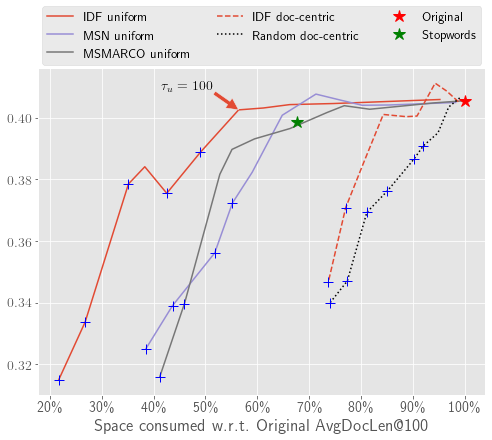

ndcg10


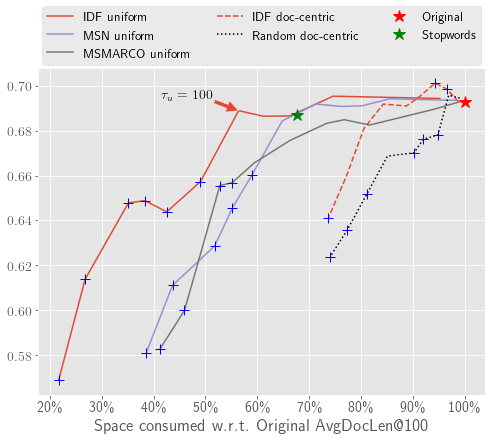

78.19981481481481
2020
map


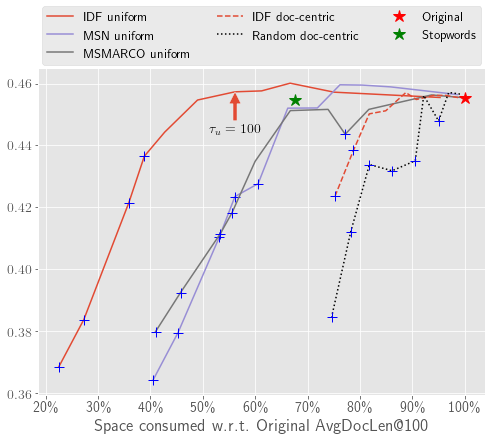

ndcg10


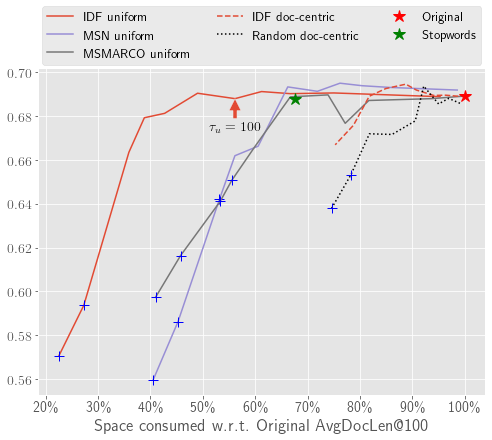

78.02066332378222
dev
mrr


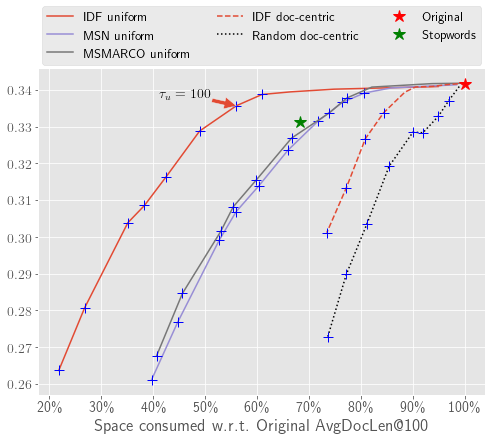

In [26]:
!mkdir -p repro

import os
MEASURES={
    "map" : "AP(rel=2)@1000",
    "ndcg10" : "nDCG@10",
#    "mrr" : "RR(rel=2)@10"
}

baselines = {
    "baseline" : ("Original", "/nfs/craigm/staticPruning/results/repro/baseline_%s/results_df.pkl", "r*"),
    "stopwords" : ("Stopwords", "/nfs/craigm/staticPruning/results/repro/Cstops_uniform_%s/results_df.pkl", "g*")
}

for y in ["2019", "2020", "dev"]:
#for y in ["2019"]:
    bname, location, symbol = baselines['baseline']
    baselineDf = pd.read_pickle(location % y)
    
    x_base = baselineDf.iloc[0]["AvgDoclen@100"]
    print(x_base)
    print(y)
    measures = MEASURES
    if y == 'dev':
        measures = {'mrr' : 'RR@10'}
    for mkey in measures: 
        print(mkey)
        lines = {}

        if os.path.exists("/nfs/craigm/staticPruning/results/repro/uniform_%s/results_df.pkl" % y):
            lines["IDF uniform"] = eval_and_signifiance("/nfs/craigm/staticPruning/results/repro/uniform_%s/", y)
        if os.path.exists("/nfs/craigm/staticPruning/results/repro/uniform_msn_%s/results_df.pkl" % y):
            lines["MSN uniform"] = eval_and_signifiance("/nfs/craigm/staticPruning/results/repro/uniform_msn_%s/", y)
        if os.path.exists("/nfs/craigm/staticPruning/results/repro/uniform_msmarco_%s/results_df.pkl" % y):
            lines["MSMARCO uniform"] = eval_and_signifiance("/nfs/craigm/staticPruning/results/repro/uniform_msmarco_%s/", y)
        if os.path.exists("/nfs/craigm/staticPruning/results/repro/doccentric_%s/results_df.pkl" % y):
            lines["IDF doc-centric"] = eval_and_signifiance("/nfs/craigm/staticPruning/results/repro/doccentric_%s/", y)
        if os.path.exists("/nfs/craigm/staticPruning/results/repro/random_doccentric_%s/results_df.pkl" % y):
            lines["Random doc-centric"] = eval_and_signifiance("/nfs/craigm/staticPruning/results/repro/random_doccentric_%s/", y)

        do_plot(
            lines,
            measure=measures[mkey],
            significance=True,
            ylabel=False,
            x_base=x_base
        )
        red_col = plt.gca().lines[0].get_color()
        u100_df = lines["IDF uniform"][lines["IDF uniform"].name == 'uniform_100']

        x_arrow, y_arrow = u100_df.iloc[0]["AvgDoclen@100"]/x_base, u100_df.iloc[0][measures[mkey]]
        if y == '2019':
            dx, dy = -0.1, 0.01
        elif y == '2020':
            dx, dy = 0, -0.01
        elif y == 'dev':
            dx, dy = -0.1, 0.005
        plt.annotate('$\\tau_u=100$', ha = 'center', va = 'top', xy = (x_arrow, y_arrow), xytext = (x_arrow+dx, y_arrow+dy),arrowprops = {'facecolor' : red_col})

        for b in baselines:
            bname, location, symbol = baselines[b]
            baselineDf = pd.read_pickle(location % y)
            plt.plot([baselineDf.iloc[0]["AvgDoclen@100"]]/x_base, [baselineDf.iloc[0][measures[mkey]]], symbol, label=bname, markersize=12)
        plt.legend(ncol=2)
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.21), ncol=3, prop={"size":13})
        plt.savefig("repro/%s_%s.pdf" % (y, mkey),
            bbox_inches='tight', 
            pad_inches=0)
        plt.show()